# Deep Q Learning Algorithm

## Introduction

This notebook reproduce the DeepQLearning network and then use this algorithm to control "CartPole" game.

Also, this code refers [MorvanZhou](https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5_Deep_Q_Network/DQN_modified.py) and [ljp](https://github.com/ljpzzz/machinelearning/blob/master/reinforcement-learning/dqn.py)

## Import Library

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf

In [2]:
tf.disable_eager_execution()
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
tf.__version__

'2.6.0'

## Code Project

In [352]:
np.random.seed(1)
tf.set_random_seed(1)

In [305]:
class DeepQLearning:
    def __init__(self, 
                 n_features, 
                 n_actions, 
                 learning_rate = 0.0001,
                 reward_decay = 0.8, 
                 e_greedy = 0.9, 
                 e_greedy_delta = 0.0001, 
                 e_greedy_min = 0.05, 
                 memory_size = 500, 
                 batch_size = 64,
                 target_replace_iter = 10):
        self.n_features = n_features
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.epsilon_delta = e_greedy_delta
        self.epsilon_min = e_greedy_min
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.target_replace_iter = target_replace_iter
        
        self.sess = tf.Session()
        
        self._build_network()
        
        self.sess.run(tf.global_variables_initializer())
                
        t_params = tf.get_collection(tf.GraphKeys.VARIABLES, scope='target_net')
        e_params = tf.get_collection(tf.GraphKeys.VARIABLES, scope='eval_net')

        with tf.variable_scope('target_replacement'):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.summary_op = tf.summary.merge_all()
        
        
        self.memory = np.zeros((memory_size, 2 * n_features + 2))
        self.memory_counter = 0 
        
        
    def _build_network(self):
        self.observations = tf.placeholder(tf.float32, shape = (None, self.n_features))
        self.observations_next = tf.placeholder(tf.float32, shape = (None, self.n_features))
        self.actions = tf.placeholder(tf.int32, shape = (None,))
        self.rewards = tf.placeholder(tf.float32, shape = (None,))
        
        with tf.variable_scope("eval_net"):
            eval_fc1 = tf.layers.dense(self.observations, 16, tf.nn.relu, 
                              kernel_initializer=tf.random_normal_initializer(0., 0.3), 
                              bias_initializer=tf.constant_initializer(0.1))       
            #tf.summary.histogram("fc1_tensor", fc1)
            self.q_eval_net = tf.layers.dense(eval_fc1, self.n_actions,
                              kernel_initializer=tf.random_normal_initializer(0., 0.3), 
                              bias_initializer=tf.constant_initializer(0.1))
            #tf.summary.histogram("Q_tensor", self.q_eval)
            
        with tf.variable_scope("target_net"):
            target_fc1 = tf.layers.dense(self.observations_next, 16, tf.nn.relu, 
                              kernel_initializer=tf.random_normal_initializer(0., 0.3), 
                              bias_initializer=tf.constant_initializer(0.1))       
            self.q_target_net = tf.layers.dense(target_fc1, self.n_actions,
                              kernel_initializer=tf.random_normal_initializer(0., 0.3), 
                              bias_initializer=tf.constant_initializer(0.1))
        
        with tf.variable_scope("q_eval"):
            hot_code_actions = tf.one_hot(self.actions, self.n_actions) # shape: [None, n_actions]
            self.q_eval = tf.reduce_sum(tf.multiply(self.q_eval_net, hot_code_actions), axis = 1)
    
        with tf.variable_scope("q_target"):
            self.q_target = tf.stop_gradient(self.gamma * tf.reduce_max(self.q_target_net, axis = 1) + self.rewards)
        
        with tf.variable_scope("loss"):
            self.loss = tf.losses.mean_squared_error(labels = self.q_target, predictions = self.q_eval)
            tf.summary.scalar("loss_of_LR", self.loss)
        
        with tf.variable_scope("train"):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
    
    def store_transition(self, s, a, r, s_):
        now = np.hstack([s, [a, r], s_])
        
        if self.memory_counter < self.memory_size:
            self.memory[self.memory_counter] = now
        else:
            index = self.memory_counter % self.memory_size
            self.memory[index] = now
        
        self.memory_counter += 1
        
    
    def train(self, iteration):
        # sample from memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size = self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size = self.batch_size)
        batch_memory = self.memory[sample_index, :]
        
        # get state,action,reward,next_state from sample data
        s = batch_memory[:, :self.n_features]
        a = batch_memory[:, self.n_features]
        r = batch_memory[:, self.n_features+1]
        s_ = batch_memory[:, self.n_features+2:]

        # learning from data
        _, merged = self.sess.run([self.train_op, self.summary_op], feed_dict = {
            self.observations: s,
            self.actions: a,
            self.rewards: r,
            self.observations_next: s_,
        })
        
        # if necessary, renew parameter of target network
        if iteration % self.target_replace_iter == 1:
            self.sess.run([self.target_replace_op])
        
        return merged
        
    def predict(self, s):
        
        # eplison - greedy
        if np.random.uniform() < self.epsilon:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_delta
            return np.random.randint(self.n_actions)
        else:
            Q = self.sess.run(self.q_eval_net, feed_dict = {
            self.observations : s[np.newaxis, :]
        })
            return np.argmax(Q)
        
        

In [306]:
tf.get_collection(tf.GraphKeys.VARIABLES)

[<tf.Variable 'eval_net/dense/kernel:0' shape=(4, 16) dtype=float32_ref>,
 <tf.Variable 'eval_net/dense/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'eval_net/dense_1/kernel:0' shape=(16, 2) dtype=float32_ref>,
 <tf.Variable 'eval_net/dense_1/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'target_net/dense/kernel:0' shape=(4, 16) dtype=float32_ref>,
 <tf.Variable 'target_net/dense/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'target_net/dense_1/kernel:0' shape=(16, 2) dtype=float32_ref>,
 <tf.Variable 'target_net/dense_1/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'train/beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'train/beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'train/eval_net/dense/kernel/Adam:0' shape=(4, 16) dtype=float32_ref>,
 <tf.Variable 'train/eval_net/dense/kernel/Adam_1:0' shape=(4, 16) dtype=float32_ref>,
 <tf.Variable 'train/eval_net/dense/bias/Adam:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'train/eval_n

## Experiment

In [307]:
import gym

In [313]:
EPSILON_NUM = 1000
THRESHOLD = 10000

In [314]:
env = gym.make("CartPole-v1")

In [320]:
tf.reset_default_graph()

In [321]:
model = DeepQLearning(n_actions = env.action_space.n, n_features = env.observation_space.shape[0])
writer = tf.summary.FileWriter("./graphs", tf.get_default_graph())
rewards_list = []

In [322]:
# env.render()
for ep in range(EPSILON_NUM):
    last_observation = env.reset()
    total_rewards = 0
    index = 0
    while True:
        action = model.predict(last_observation)
        observation, reward, done, info = env.step(action)
        total_rewards += reward
        index += 1
        reward = -1 if done else 0.1 
        model.store_transition(last_observation, action, reward, observation)
        if model.memory_counter > model.memory_size:
            summary_merged = model.train(ep)
            writer.add_summary(summary_merged, ep)
        last_observation = observation
        if done:
            print(f"epsilon:{ep}, reward:{total_rewards}")
            rewards_list.append(total_rewards)
            break
        if index > THRESHOLD:
            rewards_list.append(total_rewards)
            break


epsilon:0, reward:24.0
epsilon:1, reward:14.0
epsilon:2, reward:26.0
epsilon:3, reward:10.0
epsilon:4, reward:31.0
epsilon:5, reward:37.0
epsilon:6, reward:32.0
epsilon:7, reward:16.0
epsilon:8, reward:31.0
epsilon:9, reward:14.0
epsilon:10, reward:20.0
epsilon:11, reward:25.0
epsilon:12, reward:13.0
epsilon:13, reward:19.0
epsilon:14, reward:29.0
epsilon:15, reward:22.0
epsilon:16, reward:73.0
epsilon:17, reward:30.0
epsilon:18, reward:25.0
epsilon:19, reward:34.0
epsilon:20, reward:18.0
epsilon:21, reward:26.0
epsilon:22, reward:14.0
epsilon:23, reward:68.0
epsilon:24, reward:19.0
epsilon:25, reward:11.0
epsilon:26, reward:24.0
epsilon:27, reward:21.0
epsilon:28, reward:26.0
epsilon:29, reward:9.0
epsilon:30, reward:16.0
epsilon:31, reward:32.0
epsilon:32, reward:31.0
epsilon:33, reward:11.0
epsilon:34, reward:31.0
epsilon:35, reward:24.0
epsilon:36, reward:38.0
epsilon:37, reward:15.0
epsilon:38, reward:43.0
epsilon:39, reward:42.0
epsilon:40, reward:19.0
epsilon:41, reward:14.0
eps

epsilon:328, reward:422.0
epsilon:329, reward:433.0
epsilon:330, reward:500.0
epsilon:331, reward:463.0
epsilon:332, reward:500.0
epsilon:333, reward:500.0
epsilon:334, reward:450.0
epsilon:335, reward:420.0
epsilon:336, reward:445.0
epsilon:337, reward:420.0
epsilon:338, reward:366.0
epsilon:339, reward:367.0
epsilon:340, reward:498.0
epsilon:341, reward:435.0
epsilon:342, reward:417.0
epsilon:343, reward:422.0
epsilon:344, reward:500.0
epsilon:345, reward:491.0
epsilon:346, reward:500.0
epsilon:347, reward:500.0
epsilon:348, reward:397.0
epsilon:349, reward:31.0
epsilon:350, reward:24.0
epsilon:351, reward:10.0
epsilon:352, reward:10.0
epsilon:353, reward:25.0
epsilon:354, reward:29.0
epsilon:355, reward:23.0
epsilon:356, reward:23.0
epsilon:357, reward:12.0
epsilon:358, reward:29.0
epsilon:359, reward:32.0
epsilon:360, reward:24.0
epsilon:361, reward:12.0
epsilon:362, reward:456.0
epsilon:363, reward:238.0
epsilon:364, reward:450.0
epsilon:365, reward:500.0
epsilon:366, reward:338.0

epsilon:648, reward:61.0
epsilon:649, reward:74.0
epsilon:650, reward:51.0
epsilon:651, reward:95.0
epsilon:652, reward:105.0
epsilon:653, reward:89.0
epsilon:654, reward:369.0
epsilon:655, reward:280.0
epsilon:656, reward:200.0
epsilon:657, reward:156.0
epsilon:658, reward:160.0
epsilon:659, reward:162.0
epsilon:660, reward:156.0
epsilon:661, reward:152.0
epsilon:662, reward:139.0
epsilon:663, reward:133.0
epsilon:664, reward:140.0
epsilon:665, reward:132.0
epsilon:666, reward:167.0
epsilon:667, reward:147.0
epsilon:668, reward:141.0
epsilon:669, reward:125.0
epsilon:670, reward:141.0
epsilon:671, reward:128.0
epsilon:672, reward:140.0
epsilon:673, reward:125.0
epsilon:674, reward:120.0
epsilon:675, reward:123.0
epsilon:676, reward:122.0
epsilon:677, reward:119.0
epsilon:678, reward:124.0
epsilon:679, reward:126.0
epsilon:680, reward:126.0
epsilon:681, reward:127.0
epsilon:682, reward:117.0
epsilon:683, reward:130.0
epsilon:684, reward:125.0
epsilon:685, reward:122.0
epsilon:686, rewa

epsilon:980, reward:18.0
epsilon:981, reward:15.0
epsilon:982, reward:18.0
epsilon:983, reward:17.0
epsilon:984, reward:15.0
epsilon:985, reward:18.0
epsilon:986, reward:12.0
epsilon:987, reward:21.0
epsilon:988, reward:18.0
epsilon:989, reward:14.0
epsilon:990, reward:16.0
epsilon:991, reward:17.0
epsilon:992, reward:20.0
epsilon:993, reward:18.0
epsilon:994, reward:18.0
epsilon:995, reward:19.0
epsilon:996, reward:19.0
epsilon:997, reward:17.0
epsilon:998, reward:19.0
epsilon:999, reward:15.0


## Result

In [323]:
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

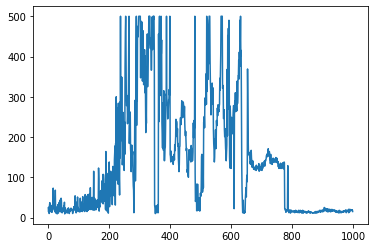

In [328]:
sns.lineplot(list(range(len(rewards_list))),rewards_list)

 这个还是很奇怪的，到了200iter的时候很大，之后反而不收敛了。

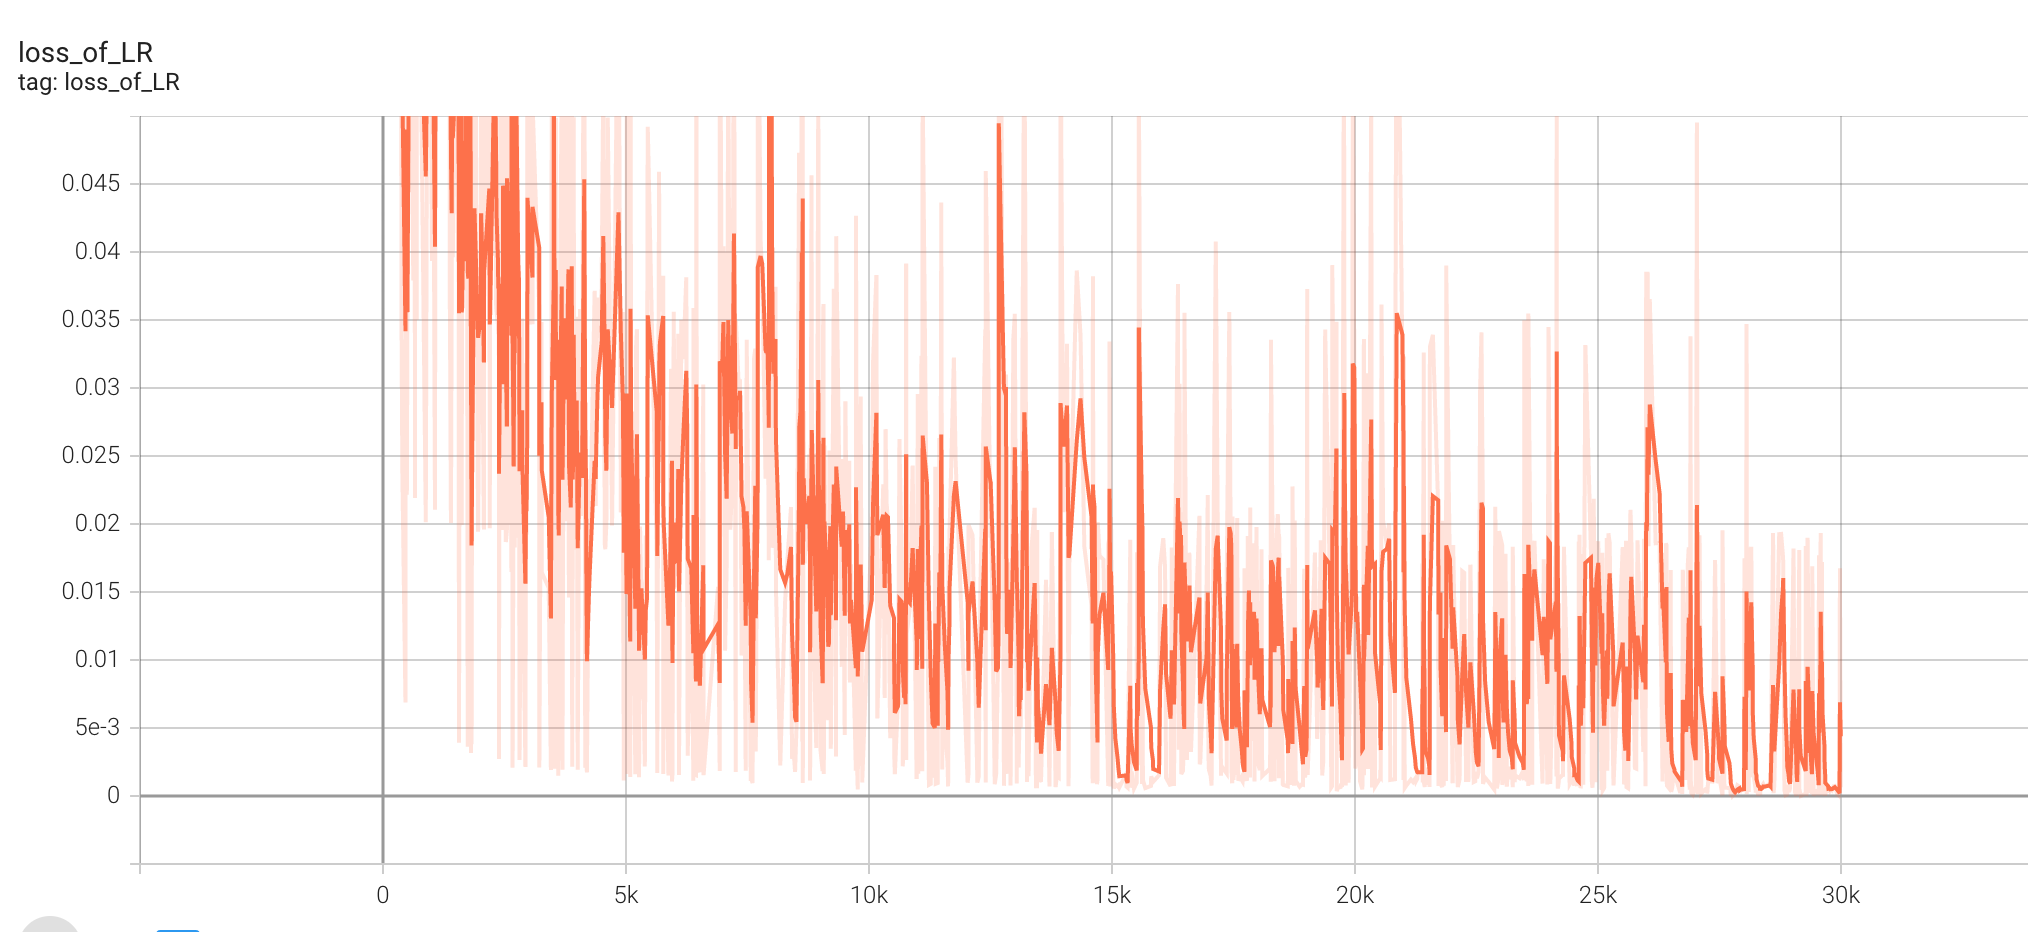